# Analysis of Pokedex Data
The *Pokemon* series of video games holds a special place in my heart. In this series, the player travels across a fantastical world, capturing a menagerie of tameable monsters, training them, and dueling them against other monster trainers to become the world champion. Each monster, called a "Pokemon", has a number of features and traits, which are recorded in an encyclopedia of knowledge known as the Pokedex. These traits include power statistics, combat moves, elemental type, and a host of other data points that we can analyze. This project aims to determine which Pokemon is the strongest and which qualities suggest a strong Pokemon.
## Questions to Answer
In order to determine which Pokemon are strong, let's break down some of the questions we should explore:
- Which Pokemon have the best stats?
- How do different factors such as type, region, height, weight, etc affect stat values?
- Which Pokemon become strongest the fastest?

An important note on the *Pokemon* series is that the player can only use 6 different Pokemon at a given time. With that in mind, I want to use the results of this data to determine the *best possible collection of 6 Pokemon* to maximize my chances of winning.

## The Source
The data used in this analysis comes from the sources below. In order to perform more detailed analysis, I arranged the data into a SQL schema, which is included in the project folder. CSVs for each table were created in Excel and imported into SQL via Python's sqlite3 and pandas modules.

Data sources:  
https://www.kaggle.com/datasets/rounakbanik/pokemon  
https://www.serebii.net/games/exp.shtml  
https://bulbapedia.bulbagarden.net/wiki/Region

In [1]:
%pip install seaborn
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
  Using cached statsmodels-0.14.0-cp38-cp38-win_amd64.whl (9.4 MB)
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)
  Using cached scipy-1.10.1-cp38-cp38-win_amd64.whl (42.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
conn = sqlite3.connect('pokedex.db')

# Question 0: What Are Pokemon?
Before we can properly begin, I am sure many of my readers are unfamiliar with the *Pokemon* series of video games. With that in mind, this section will briefly explain the nature of the game, what exactly a "Pokemon" is, and why the information we gathered here can be useful as we play the game.

For consistency, I will refer to the series of games as *Pokemon* (in italics), while the creatures themselves I will refer to as Pokemon (without italics).

## The Game
Every *Pokemon* game uses the same basic formula. Each game is set in a fictional world populated by wild creatures known as Pokemon. The player, a Pokemon Trainer, aims to encounter these Pokemon, capture them, and train them by battling other Pokemon and other Pokemon Trainers. As Pokemon battle, they get stronger, gain new abilities, and learn more powerful techniques. Over time, the player collects a variety of Pokemon, and they meet interesting characters and uncover mysterious plots along the way.

The goal of the game is to defeat a series of exceptional Trainers called Gym Leaders, each of whom operates a Pokemon Gym to encourage training. Defeating a Gym Leader in a Pokemon battle earns the player a Gym Badge, and obtaining Badges from all eight Gym Leaders enables the player to challenge the Elite Four, who are some of the strongest Pokemon Trainers in the world. Once the player beats these four Trainers, they finally face the Champion, the strongest Trainer in the world. Should the player win, they become the new world champion, and take on the title of strongest Trainer.

## So What Are Pokemon?
Pokemon, a portmanteau of "pocket" and "monster", are fantastical animals, monsters, and supernatural creatures that populate the world of the *Pokemon* series. Some Pokemon are reminiscent of real-world animals, like the insectile Caterpie and Weedle, while others share similarities to creatures from folklore, such as the nine-tailed fox Ninetales. Others originate from technology, while still others are completely strange and unfamiliar. There are over 700 Pokemon across 7 generations of games, each with its own strengths and weaknesses.

### How are Pokemon Designed?
Within the game's code, Pokemon are programmed with a number of defining characteristics. These include six numerical stats, which determine the Pokemon's effectiveness in battle, as well as type, level, experience points, height, weight, gender, and catch rate, among others. The most important of these values for the purposes of this project are the stats, which will be explained in greater detail below.

### Legendary Pokemon
Every *Pokemon* game features a number of *Legendary* Pokemon, exceptionally rare Pokemon that are naturally strong. Legendary Pokemon have heightened stats, low catch rates, and powerful movesets that set them apart from other Pokemon. Many of the strongest Pokemon are legendary - however, their enhanced abilities tend to skew data in favor of higher values. For this reason, when answering my questions, I analyze two separate sets of data: one which contains all Pokemon, and one in which legendaries are excluded.

Now, with the preliminaries out of the way, let's begin.

## Question 1: Which Pokemon have the best stats?
In the Pokemon games, each Pokemon has 6 distinct stats, each with its own value determining its strength:
- **Attack** determines the damage a Pokemon deals with physical moves.
- **Defense** determines the damage a Pokemon receives from physical moves.
- **HP** determines how much damage a Pokemon can take before it faints.
- **Special Attack** determines how much damage a Pokemon deals with special moves.
- **Special Defense** determines how much damage a Pokemon receives from special moves.
- **Speed** determines how quickly the Pokemon can act in battle.

Combining the values of all of a Pokemon's stats returns its **Base Stat Total**, which is a good indicator of a Pokemon's overall strength. So in our journey to find the strongest Pokemon, let's begin by looking at the Pokemon with the highest base totals.

#### With Legendaries

In [4]:
query = """
    SELECT
    name AS Name,
    base_total AS Base_Total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    ORDER BY base_total DESC
    LIMIT 10;
    """
df = pd.read_sql(query, conn)
print(df)

       Name  Base_Total
0    Kyogre         770
1   Groudon         770
2    Arceus         720
3   Zygarde         708
4    Kyurem         700
5    Mewtwo         680
6     Lugia         680
7     Ho-Oh         680
8  Rayquaza         680
9    Dialga         680



These 10 Pokemon have the highest base stat totals of all Pokemon, and the top 5 (Kyogre through Kyurem) have totals over 700. That's pretty strong!

So we're done, right? We just pick the 6 Pokemon with the highest base totals and move on with our day.

Unfortunately, the base stat total obscures several pieces of information. While the base total shows if a Pokemon is *broadly* powerful, we can't see how the individual stats are distributed, which could influence the Pokemon's effectiveness in battle. For instance, a Pokemon with high Speed will likely move first, but if its Attack and Special Attack are low, it won't deal enough damage to defeat its opponent quickly.

We want our Pokemon to have as few weaknesses as possible. One way to determine this is to check the standard deviation between stats, rather than the total of all stats. A high SD means the stats are spread out, while a low SD means the stats are close together, so we'll look for the Pokemon with low SDs, but high base totals.

In [5]:
query = """
    SELECT
    name AS Name,
    base_total AS Base_Total,
    base_total/6 AS Average,
    sqrt((pow((attack - base_total/6), 2)
        + pow((defense - base_total/6), 2)
        + pow((hp - base_total/6), 2)
        + pow((sp_attack - base_total/6), 2)
        + pow((sp_defense - base_total/6), 2)
        + pow((speed - base_total/6), 2))/6) AS SD
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE base_total >= 600 AND sd <= 20
    ORDER BY average DESC, sd ASC
    LIMIT 10;
    """
df = pd.read_sql(query, conn)
print(df)

DatabaseError: Execution failed on sql '
    SELECT
    name AS Name,
    base_total AS Base_Total,
    base_total/6 AS Average,
    sqrt((pow((attack - base_total/6), 2)
        + pow((defense - base_total/6), 2)
        + pow((hp - base_total/6), 2)
        + pow((sp_attack - base_total/6), 2)
        + pow((sp_defense - base_total/6), 2)
        + pow((speed - base_total/6), 2))/6) AS SD
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE base_total >= 600 AND sd <= 20
    ORDER BY average DESC, sd ASC
    LIMIT 10;
    ': no such function: sqrt


Look at the difference! The only Pokemon still on our list are Arceus, which sits at the top with an SD of 0, and Dialga, which previously held 10th place and now holds 6th. While the totals from this new list are a slightly weaker overall, the low SDs indicate a more consistent spread of stat values. For curiosity's sake, let's look at our original list, but include their individual stat values as well.

In [ ]:
query = """
    SELECT
    name AS Name,
    attack AS Attack,
    defense AS Defense,
    hp AS HP,
    sp_attack AS Sp_Attack,
    sp_defense AS Sp_Defense,
    speed AS Speed,
    sqrt((pow((attack - base_total/6), 2)
        + pow((defense - base_total/6), 2)
        + pow((hp - base_total/6), 2)
        + pow((sp_attack - base_total/6), 2)
        + pow((sp_defense - base_total/6), 2)
        + pow((speed - base_total/6), 2))/6) AS SD
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    ORDER BY base_total DESC
    LIMIT 10;
    """
df = pd.read_sql(query, conn)
print(df)

       Name  Attack  Defense   HP  Sp_Attack  Sp_Defense  Speed         SD
0    Kyogre     150       90  100        180         160     90  36.249138
1   Groudon     180      160  100        150          90     90  36.249138
2    Arceus     120      120  120        120         120    120   0.000000
3   Zygarde     100      121  216         91          95     85  45.247468
4    Kyurem     120       90  125        170         100     95  27.037012
5    Mewtwo     110       90  106        154          90    130  22.678918
6     Lugia      90      130  106         90         154    110  22.678918
7     Ho-Oh     130       90  106        110         154     90  22.678918
8  Rayquaza     150       90  105        150          90     95  26.407070
9    Dialga     120      120  100        150         100     90  19.723083



We can see some of our strongest Pokemon have huge differences in their stat values. Kyogre's Defense is 90 points lower than its Special Attack, and Zygarde's HP is more than twice as high as its Special Attack, Special Defense, *and* Speed. These are clearly poor choices if we value consistency over pure strength. On the other hand, Arceus and Dialga have both high stat totals and consistent stat distributions, so they're definitely contenders for the final list.

#### Without Legendaries

In [ ]:
query = """
    SELECT
    name AS Name,
    base_total AS Base_Total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE is_legendary = 0
    ORDER BY base_total DESC
    LIMIT 10;
    """
df = pd.read_sql(query, conn)
print(df)

         Name  Base_Total
0     Slaking         670
1  Wishiwashi         620
2   Dragonite         600
3   Tyranitar         600
4   Salamence         600
5   Metagross         600
6    Garchomp         600
7   Hydreigon         600
8      Goodra         600
9     Kommo-o         600



Without legendaries, we have no Pokemon with base stat totals higher than 700, with Slaking topping the list at 670. We should once again check our list for consistency as well, so let's see how the list changes when we look for Pokemon with low SDs, but high base stat totals.

In [ ]:
query = """
    SELECT
    name AS Name,
    base_total AS Base_Total,
    base_total/6 AS Average,
    sqrt((pow((attack - base_total/6), 2)
        + pow((defense - base_total/6), 2)
        + pow((hp - base_total/6), 2)
        + pow((sp_attack - base_total/6), 2)
        + pow((sp_defense - base_total/6), 2)
        + pow((speed - base_total/6), 2))/6) AS SD
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE base_total >= 500 AND sd <= 20 AND is_legendary = 0
    ORDER BY average DESC, sd ASC
    LIMIT 10;
    """
df = pd.read_sql(query, conn)
print(df)

         Name  Base_Total  Average         SD
0   Hydreigon         600      100  12.369317
1     Kommo-o         600      100  16.329932
2    Garchomp         600      100  16.421531
3   Dragonite         600      100  16.643317
4   Salamence         600      100  18.929694
5    Arcanine         555       92  10.716032
6     Kingdra         540       90   7.637626
7  Electivire         540       90  17.879224
8   Magmortar         540       90  18.610033
9   Charizard         534       89  11.575837



Here we can see that our top Pokemon are much less powerful than the original top 10, but they sport low SDs and are therefore more consistent. Hydreigon, Arcanine, Kingdra, and Charizard all have SDs less than 15 and base totals above 500, making them good choices for consistency.


## Question 2: How do different factors affect stat values?
Pokemon have a lot of characteristics outside of just stat values:
- Up to two **types**
- **Generation**, or which game it's from
- **Height** and **weight**
- **Percentage Male** in the wild
- **Catch rate**, or how difficult it is to catch

There are many more characteristics, of course, but I'm going to focus on these for now because they seem the most interesting. Let's take them one at a time.


### Type
A type is a core quality of a Pokemon that determines its powers in battle. There are 18 types, many associated with an "element" from classical mythology. Each Pokemon can have one or two types, and each move has a type as well. Moves of some types are especially strong or weak against Pokemon of other types; for example, against the Fire-type Charmander, a Water-type move will deal twice as much damage, while a Grass-type move will deal half as much damage.

As I played the games, I've observed that some types tend to be stronger than others. Let's see if that's actually true by comparing type to base stat total. We'll consider both of a Pokemon's types in our analysis, and we'll use a box plot to represent the distribution of base totals.

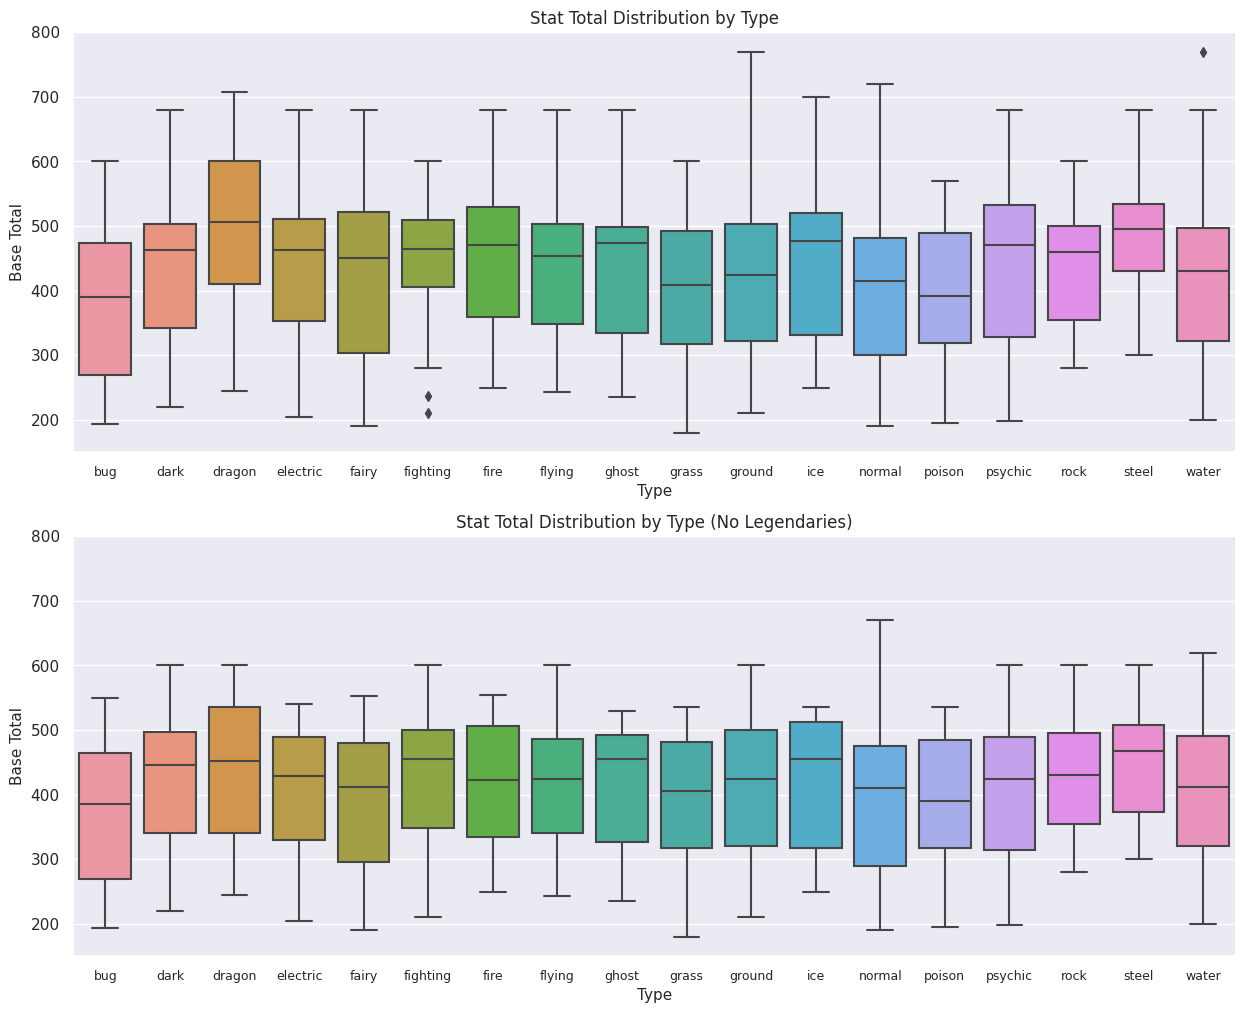

In [ ]:
query1 = """
    SELECT
    overview.pokedex_number AS dex_number,
    name,
    type1,
    type2,
    base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    ORDER BY type1;
    """

query2 = """
    SELECT
    type1,
    type2,
    base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE is_legendary = 0
    ORDER BY type1;
    """

df1 = pd.read_sql(query1, conn)
df2 = pd.read_sql(query2, conn)

df1m = df1.melt('base_total', value_vars=('type1', 'type2'), var_name='prim_sec', value_name='type')
df2m = df2.melt('base_total', value_vars=('type1', 'type2'), var_name='prim_sec', value_name='type')

fig, (ax1, ax2) = plt.subplots(2, 1)
sns.set_theme(palette='Set2', style='darkgrid')

ax1.set_title('Stat Total Distribution by Type')
sns.boxplot(
    data=df1m, x='type', y='base_total', ax=ax1
)
ax1.set_xlabel('Type', fontsize=11)
ax1.set_ylabel('Base Total', fontsize=11)
ax1.tick_params(axis='x', labelsize=9)
ax1.set_ylim([150, 800])

ax2.set_title('Stat Total Distribution by Type (No Legendaries)')
sns.boxplot(
    data=df2m, x='type', y='base_total', ax=ax2
)
ax2.set_xlabel('Type', fontsize=11)
ax2.set_ylabel('Base Total', fontsize=11)
ax2.tick_params(axis='x', labelsize=9)
ax2.set_ylim([150, 800])

fig.set_figheight(12)
fig.set_figwidth(15)

#### With Legendaries
We can see here that the median total for most types hovers around 450 to 475. Dragon types are narrowly the strongest, with a median of 507 (and indeed the only type with a median above 500). Steel is a close second with a median just under 500, but we can see that Dragon has a larger distribution above the median, reaching 600 in its upper quartile, while Steel only reaches 533 in its upper quartile, a full 67 points less than Dragon. We also see Psychic types with a high upper quartile, reaching 533 along with Steel, with Fire types close behind at 530 for the upper quartile.

The Bug type, on the other hand, is confidently the weakest type, with a median of 390 and the lowest maximum of all types at 600. Poison is a close second, with a median a hair under 400. Unfortunately for me, my favorite type, Grass, is stuck just above Poison - despite its symmetric distribution, it maintains a low 405 median, a lower quartile on par with Poison, and an upper quartile under 500.

So the strongest types tend towards Dragon, Steel, Psychic, and Fire, while Bug, Poison, and Grass tend to be weak. This aligns with the data we've seen already - of the top 10 Pokemon with highest base stat totals, 4 are Dragon type. When we're choosing our team, Dragon type Pokemon will likely be strong contenders.

#### Without Legendaries
Without legendaries, Steel replaces Dragon as the type with the highest median at 467. Fighting and Ice tie for second highest median at 455, barely eking out Dragon and Ghost at 452. Dragon still boasts the highest upper quartile at 535, but Fire and Ice break the 500 mark for their upper quartiles as well. Psychic has dropped completely out of the race, with a median falling to 425 and an upper quartile under 500. Bug, Poison, and Grass remain on the lower end of the spectrum, but difference between them and the other types is smaller than before.


### Generation
The 7 generations of Pokemon (actually there are more, but my dataset only includes the first 7) each take place in a different fantastical region, and each adds over 100 new Pokemon to the Pokedex. As I played each new game, I observed that newer generations of Pokemon seemed stronger than older ones. Let's see if my hypothesis is correct by analyzing base stat totals across regions. Once again, we'll use a box plot to analyze the distribution of base totals for each generation.

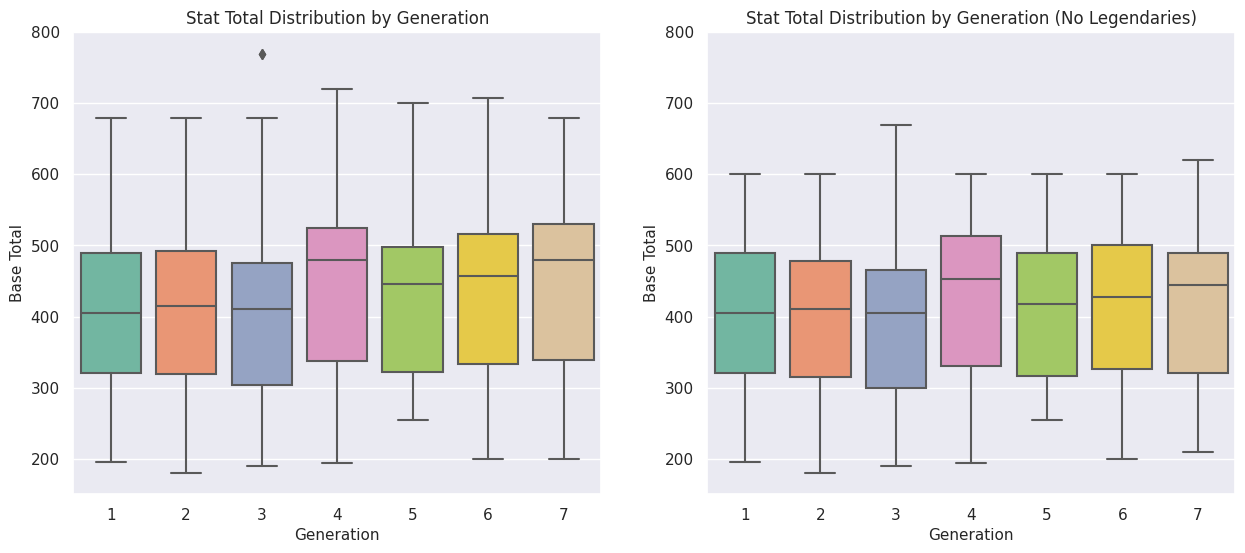

In [ ]:
query1 = """
    SELECT
    generation,
    base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    ORDER BY generation;
    """
query2 = """
    SELECT
    generation,
    base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE is_legendary = 0
    ORDER BY generation;
    """

df1 = pd.read_sql(query1, conn)
df2 = pd.read_sql(query2, conn)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('Stat Total Distribution by Generation')
sns.boxplot(
    data=df1, x='generation', y='base_total', ax = ax1
)
ax1.set_xlabel('Generation', fontsize=11)
ax1.set_ylabel('Base Total', fontsize=11)
ax1.set_ylim([150, 800])

ax2.set_title('Stat Total Distribution by Generation (No Legendaries)')
sns.boxplot(
    data=df2, x='generation', y='base_total', ax=ax2
)
ax2.set_xlabel('Generation', fontsize=11)
ax2.set_ylabel('Base Total', fontsize=11)
ax2.set_ylim([150, 800])

fig.set_figheight(6)
fig.set_figwidth(15)

#### With Legendaries
We find some interesting results here, primarily that Generations 4 and 7 share the highest median stat total at 480. Gen 4 has the highest maximum stat total of any generation at 720, with the exception of the outlier in Gen 3 at 770 (shared by Kyogre and Groudon). Most generations bottom out around 200, while Gen 5 has a significantly higher minimum at 255. The weakest generation is Gen 1, with a paltry median of 405, while Gen 2 has the lowest minimum total of any generation at 180.

So Generations 4 and 7 are pretty evenly matched for the strongest generation. Surprisingly, our top 10 list only sports 2 Pokemon from Generation 4 and none from Generation 7 - in fact, there are representatives from every generation *except* Gen 7 on that list. So while Pokemon may have gotten stronger on average with increasing generations, the *strongest* Pokemon come from other generations.

#### Without Legendaries
This data is pretty similar to our data with non-legendaries. We see that Gen 4's median of 453 now beats Gen 7's of 445, and Gen 3 now boasts the maximum stat total at 670. Other than that, the majority of the data remains in line with our previous analysis, albeit a bit lower in value. This makes sense - legendary Pokemon tend to make up the strongest subset of data for each generation, so removing those data points will make all generations slightly weaker. Notably, the generation most affected by this change is Gen 7. This generation has the most legendaries out of any generation with 18, so a sudden drop in power is expected.


### Height and Weight
Each Pokemon has a listed height (in meters) and weight (in kilograms). While this data is aesthetic and has almost no in-game bearing on a Pokemon's success in battle, I have noticed many tall Pokemon tend to also have very high stats. Likewise, heavy Pokemon seem to perform better in battles than light Pokemon. Let's take a look at these relationships - one between height and base total, and one between weight and base total. We'll use a scatter plot and plot a regression line to determine a correlation.

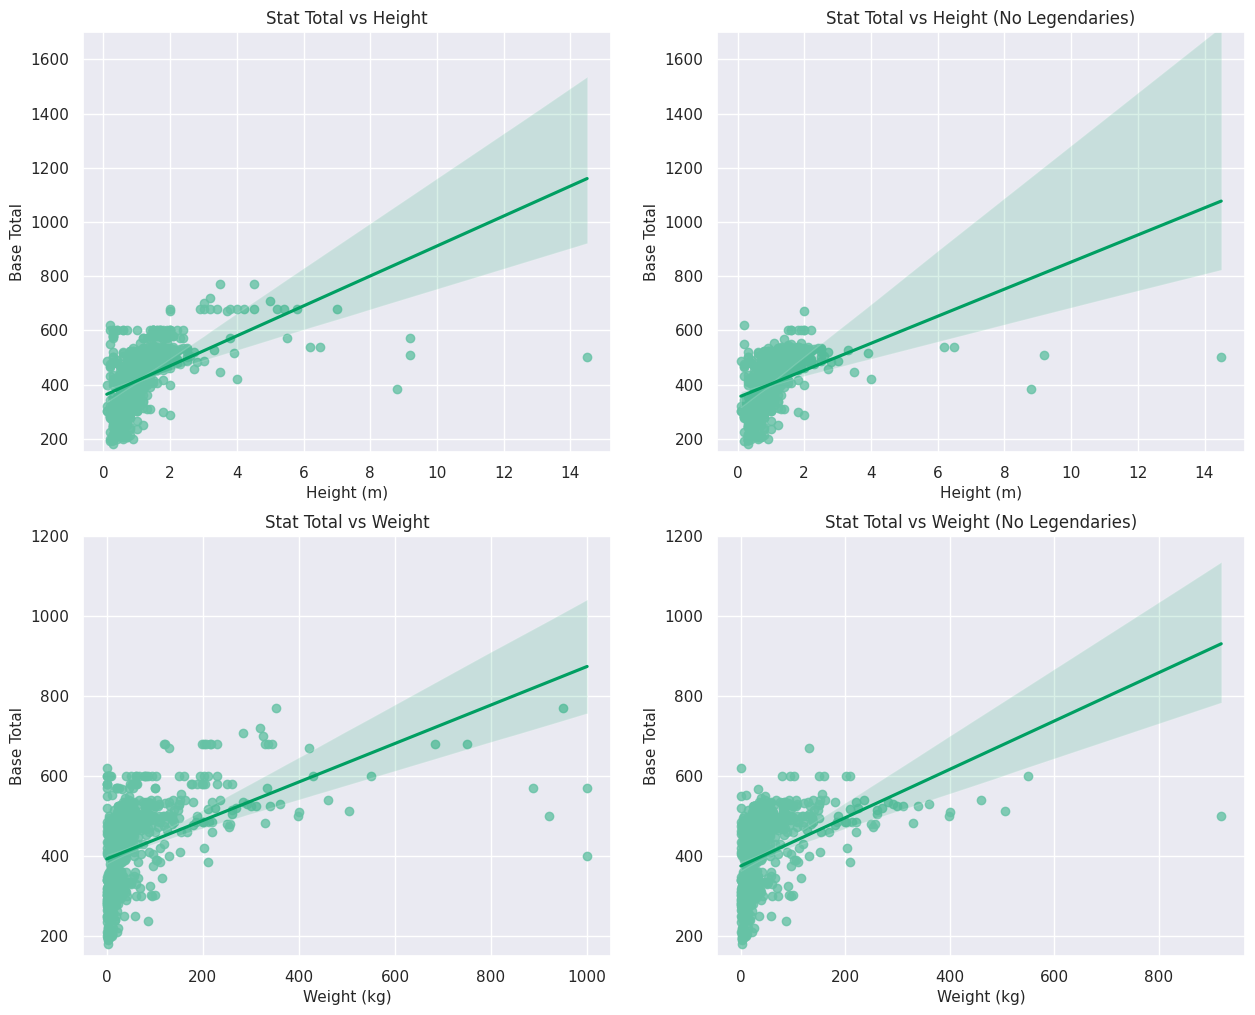

In [ ]:
query1 = """
    SELECT height_m, weight_kg, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number;
    """
query2 = """
    SELECT height_m, weight_kg, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE is_legendary = 0;
    """

df1 = pd.read_sql(query1, conn)
df2 = pd.read_sql(query2, conn)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.set_title('Stat Total vs Height')
sns.regplot(
    data=df1, x='height_m', y='base_total', ax=ax1, line_kws={'color': '#009F62'}
)
ax1.set_xlabel('Height (m)', fontsize=11)
ax1.set_ylabel('Base Total', fontsize=11)
ax1.set_ylim([150, 1700])

ax2.set_title('Stat Total vs Height (No Legendaries)')
sns.regplot(
    data=df2, x='height_m', y='base_total', ax=ax2, line_kws={'color': '#009F62'}
)
ax2.set_xlabel('Height (m)', fontsize=11)
ax2.set_ylabel('Base Total', fontsize=11)
ax2.set_ylim([150, 1700])

ax3.set_title('Stat Total vs Weight')
sns.regplot(
    data=df1, x='weight_kg', y='base_total', ax=ax3, line_kws={'color': '#009F62'}
)
ax3.set_xlabel('Weight (kg)', fontsize=11)
ax3.set_ylabel('Base Total', fontsize=11)
ax3.set_ylim([150, 1200])

ax4.set_title('Stat Total vs Weight (No Legendaries)')
sns.regplot(
    data=df2, x='weight_kg', y='base_total', ax=ax4, line_kws={'color': '#009F62'}
)
ax4.set_xlabel('Weight (kg)', fontsize=11)
ax4.set_ylabel('Base Total', fontsize=11)
ax4.set_ylim([150, 1200])

fig.set_figheight(12)
fig.set_figwidth(15)


The main thing to notice here is that both plots are highly concentrated for small values, and sparse for large values. Our regression line doesn't seem to follow the true distribution of the data, and we can see that the confidence interval gets comically large at the far right end of the regression line. It would benefit us to remove some of the larger, outlier values and only consider the highest concentration of data points. Let's see what happens if we only look at data points under a certain value - we'll select for all values under the upper quartile for each statistic and plot those with a regression.

In [ ]:
query1 = """
    SELECT height_m, weight_kg, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number;
    """
query2 = """
    SELECT height_m, weight_kg, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE is_legendary = 0;
    """
df1 = pd.read_sql(query1, conn)
df2 = pd.read_sql(query2, conn)
print('Statistic Overview')
print(df1.describe())
print('')
print('Statistic Overview (No Legendaries)')
print(df2.describe())

Statistic Overview
         height_m   weight_kg  base_total
count  781.000000  781.000000  801.000000
mean     1.163892   61.378105  422.459426
std      1.080326  109.354766  112.122026
min      0.100000    0.100000  180.000000
25%      0.600000    9.000000  320.000000
50%      1.000000   27.300000  431.000000
75%      1.500000   64.800000  500.000000
max     14.500000  999.900000  770.000000

Statistic Overview (No Legendaries)
         height_m   weight_kg  base_total
count  711.000000  711.000000  730.000000
mean     1.053868   47.933333  404.454795
std      0.919711   73.310912   97.886254
min      0.100000    0.100000  180.000000
25%      0.500000    8.550000  316.500000
50%      0.900000   24.900000  413.000000
75%      1.400000   55.900000  490.000000
max     14.500000  920.000000  670.000000


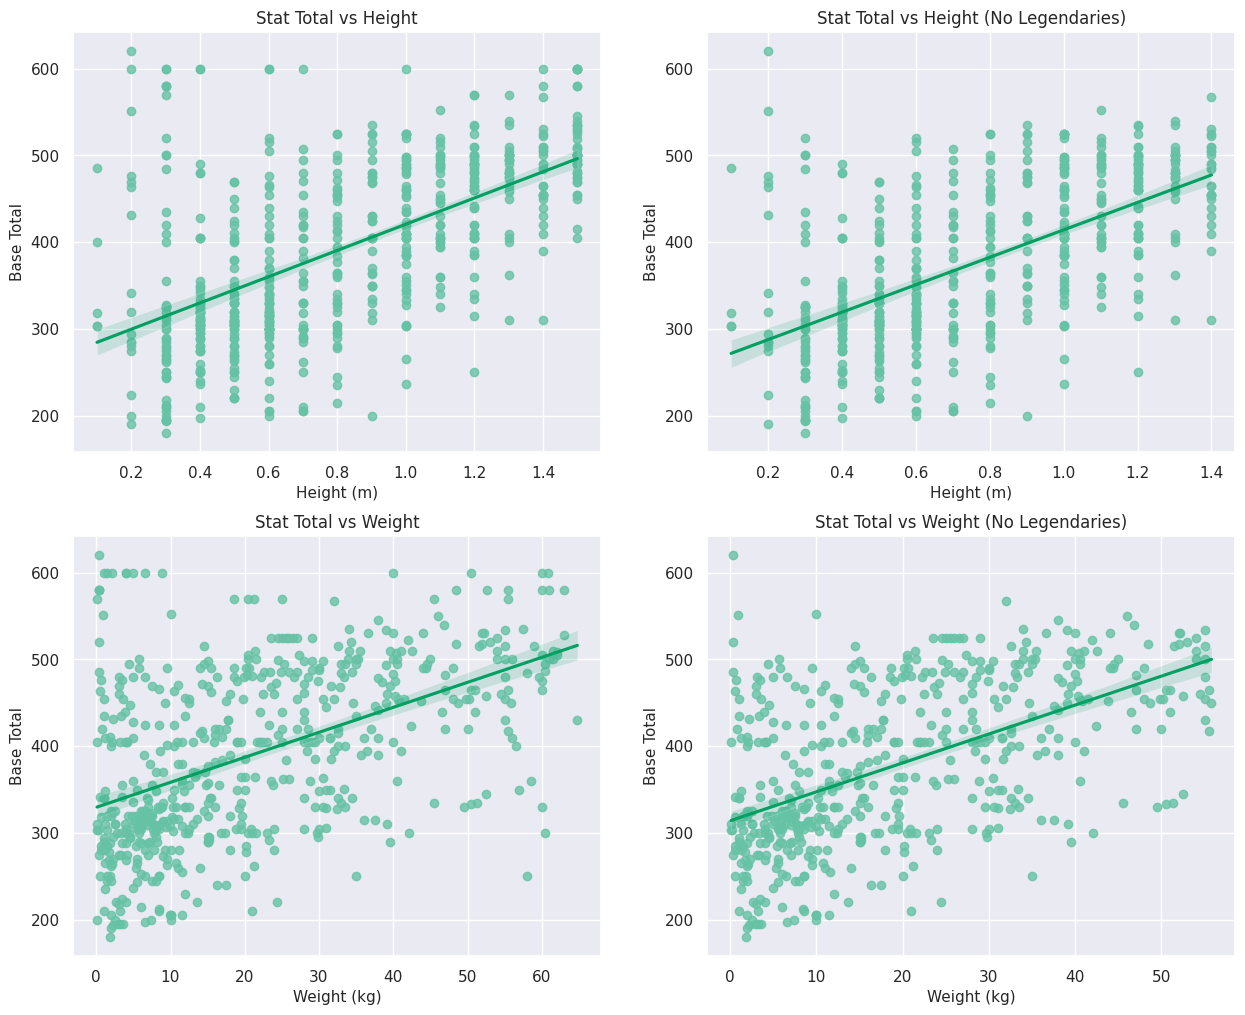

In [ ]:
query1 = """
    SELECT height_m, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE height_m <= 1.5;
    """
query2 = """
    SELECT height_m, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE is_legendary = 0 AND height_m <= 1.4;
    """
query3 = """
    SELECT weight_kg, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE weight_kg <= 64.8;
    """
query4 = """
    SELECT weight_kg, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    WHERE is_legendary = 0 AND weight_kg <= 55.9;
    """
df1 = pd.read_sql(query1, conn)
df2 = pd.read_sql(query2, conn)
df3 = pd.read_sql(query3, conn)
df4 = pd.read_sql(query4, conn)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.set_title('Stat Total vs Height')
sns.regplot(
    data=df1, x='height_m', y='base_total', ax=ax1, line_kws={'color': '#009F62'}
)
ax1.set_xlabel('Height (m)', fontsize=11)
ax1.set_ylabel('Base Total', fontsize=11)

ax2.set_title('Stat Total vs Height (No Legendaries)')
sns.regplot(
    data=df2, x='height_m', y='base_total', ax=ax2, line_kws={'color': '#009F62'}
)
ax2.set_xlabel('Height (m)', fontsize=11)
ax2.set_ylabel('Base Total', fontsize=11)

ax3.set_title('Stat Total vs Weight')
sns.regplot(
    data=df3, x='weight_kg', y='base_total', ax=ax3, line_kws={'color': '#009F62'}
)
ax3.set_xlabel('Weight (kg)', fontsize=11)
ax3.set_ylabel('Base Total', fontsize=11)

ax4.set_title('Stat Total vs Weight (No Legendaries)')
sns.regplot(
    data=df4, x='weight_kg', y='base_total', ax=ax4, line_kws={'color': '#009F62'}
)
ax4.set_xlabel('Weight (kg)', fontsize=11)
ax4.set_ylabel('Base Total', fontsize=11)

fig.set_figheight(12)
fig.set_figwidth(15)


These plots show a much more linear relationship than our previous data. Base total increases with height at a rate of around 50 points per .3m, while it increases with weight at a rate of about 50 points per 30kg. Notice from the interquartile range that the maximum values for height and weight are 14.5m and 999.9kg, respectively - many times larger than the upper quartile values. Abnormally large data points like these can manipulate our regression line. Since the majority of data points are much less than these outlier values, we get a more accurate picture by eliminating the larger heights and weights and only considering the lower majority of values.

Restricting our data in this way allows us to see the actual positive relationship between height and weight; however, base totals above 700 are not represented in either of these sets. Once again, while we can determine the linear relationship between height/weight and base total from these new plots, they don't help us determine the *strongest* Pokemon, which are likely outliers in most characteristics. That said, these broad relationships can still inform our decisions - we should expect tall Pokemon (1.2m and taller) and heavy Pokemon (40kg or heavier) to have stat totals upwards of 450.

For non-legendaries, the results don't convey a significantly different situation, with both regressions being translated down a few points while maintaining a nearly identical slope.


### Percentage Male
Each Pokemon species has a *gender ratio*, the ratio of males to females in the wild population. In game terms, this is the probability that a wild Pokemon will be male or female. Some Pokemon are always male, with a percentage of 100%. Others are always female, with a percentage of 0%. Other Pokemon have no gender at all, which will be represented with an X. Since the Pokemon games are marketed towards boys, I am interested in finding out if Pokemon that have a higher male percentage are generally stronger. Since there are only a few possibilites for gender ratio, we'll use a box plot to review the data.

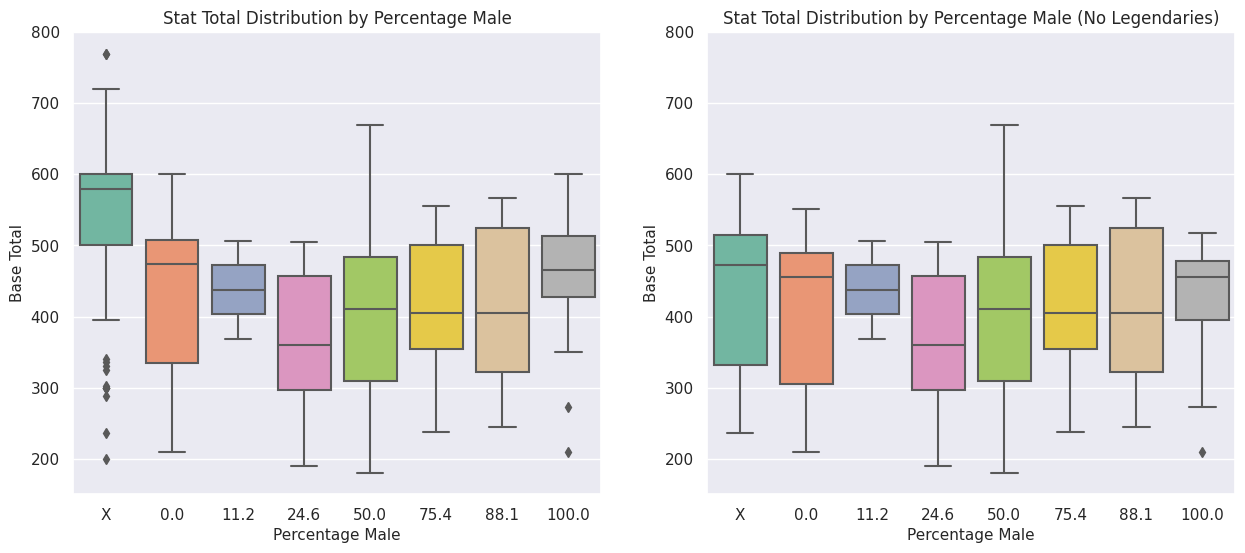

In [ ]:
query1 = """
    SELECT percentage_male, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    ORDER BY percentage_male;
    """
query2 = """
    SELECT percentage_male, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    WHERE is_legendary = 0
    ORDER BY percentage_male;
    """

df1 = pd.read_sql(query1, conn)
df1['percentage_male'] = df1['percentage_male'].fillna('X')
df2 = pd.read_sql(query2, conn)
df2['percentage_male'] = df2['percentage_male'].fillna('X')

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('Stat Total Distribution by Percentage Male')
sns.boxplot(
    data=df1, x='percentage_male', y='base_total', ax=ax1
)
ax1.set_xlabel('Percentage Male', fontsize=11)
ax1.set_ylabel('Base Total', fontsize=11)
ax1.set_ylim([150, 800])

ax2.set_title('Stat Total Distribution by Percentage Male (No Legendaries)')
sns.boxplot(
    data=df2, x='percentage_male', y='base_total', ax=ax2
)
ax2.set_xlabel('Percentage Male', fontsize=11)
ax2.set_ylabel('Base Total', fontsize=11)
ax2.set_ylim([150, 800])

fig.set_figheight(6)
fig.set_figwidth(15)


#### With Legendaries
Here we see that Pokemon with no gender (X) have the highest overall base stat totals, with a median at 580 and a lower quartile of 500. Next highest medians come from 0% and 100% male, which are within 10 points of each other (474 and 465 respectively). There appears to be an overarching trend in which medians for base stat total are higher when percentage male is both very low and very high, with the medians and quartiles evening out at 50%. The 24.6% category has the lowest median at 360, the only median under 400. So it appears that a Pokemon's percentage male has a varying effect on its stats - we can expect all-male and all-female Pokemon to be roughly stronger than others, and genderless Pokemon will beat out all other percentages.

#### Without Legendaries
Legendary Pokemon are almost all genderless, with few exceptions. As such, removing them from our results greatly diminishes the median stat totals for the genderless category (X). The median drops a full 107 points down to 473, and its lower quartile falls even lower to 331. Despite this, the genderless category still maintains the highest median. Other than that, there is no significant change to the results when legendaries are removed.


### Catch Rate
Each Pokemon that appears in the wild has a *catch rate*, which is a value that indicates how difficult the Pokemon is to catch using a standard Poke Ball. This value ranges from as low as 3 to as high as 255, with higher values indicated a better chance of catch success. Trainers can increase the likelihood of catching a Pokemon by lowering its HP, applying a status effect, or using an upgraded Poke Ball, among other things. The formula to determine a Pokemon's final catch rate is...complicated, but essentially, a higher catch rate means a Pokemon is more likely to be caught. This begs the question - do hard-to-catch Pokemon have higher base stat totals?

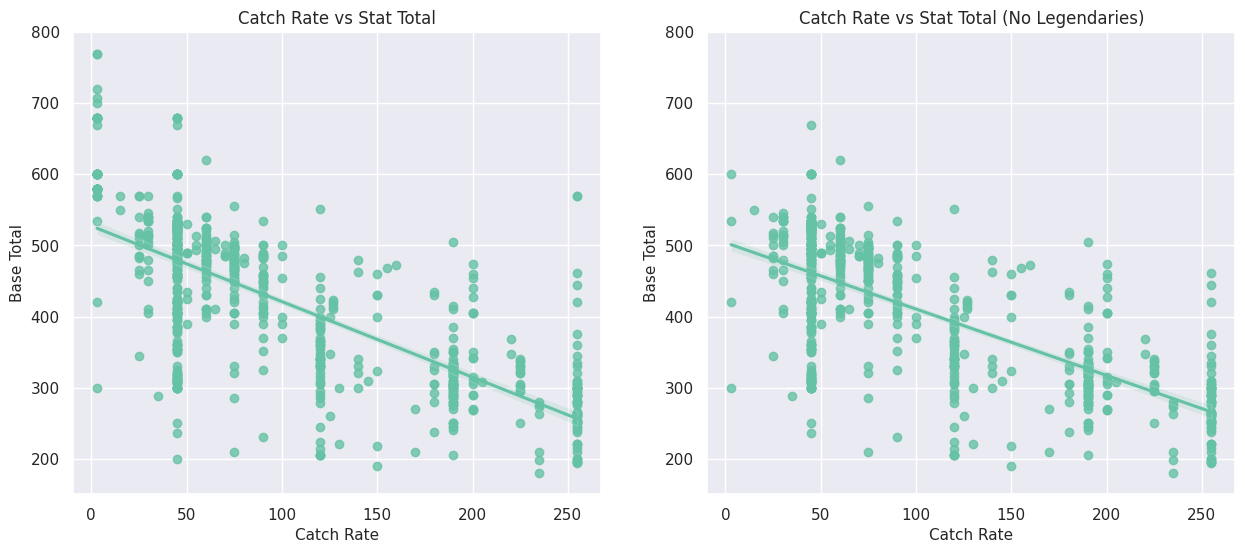

In [ ]:
query1 = """
    SELECT capture_rate AS catch_rate, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number;
    """
query2 = """
    SELECT capture_rate AS catch_rate, base_total
    FROM overview
    INNER JOIN stats
        ON overview.pokedex_number = stats.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    WHERE is_legendary = 0;
    """
df1 = pd.read_sql(query1, conn)
df2 = pd.read_sql(query2, conn)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('Catch Rate vs Stat Total')
sns.regplot(
    data=df1, x="catch_rate", y="base_total", ax=ax1
)
ax1.set_xlabel('Catch Rate', fontsize=11)
ax1.set_ylabel('Base Total', fontsize=11)
ax1.set_ylim([150, 800])

ax2.set_title('Catch Rate vs Stat Total (No Legendaries)')
sns.regplot(
    data=df2, x="catch_rate", y="base_total", ax=ax2
)
ax2.set_xlabel('Catch Rate', fontsize=11)
ax2.set_ylabel('Base Total', fontsize=11)
ax2.set_ylim([150, 800])

fig.set_figheight(6)
fig.set_figwidth(15)

#### With Legendaries
We find a negative correlation between catch rate and base total - Pokemon with high catch rates tend to be weaker overall, while Pokemon with low catch rates tend to be stronger. Roughly, for every 10 point increase in catch rate, base total decreases by about 11 points. These results make sense - strong Pokemon would naturally be more capable of resisting capture, while weak Pokemon can be easily subdued and caught with little difficulty.

#### Without Legendaries
Legendary Pokemon are especially difficult to catch, with catch rates often 50 or less. When we remove legendaries, we end up with fewer data points in the top left quandrant (low catch rate, high base total). The regression line stays roughly the same, but loses some of its steepness, sporting a 10 point increase in catch rate corresponding to about a 9 point decrease in base total.

## Question 3: Which Pokemon becomes strongest the fastest?
Usually, it's not enough to pick the strongest Pokemon for your team. An essential part of creating the strongest team is *training* your Pokemon. As Pokemon fight and win battles, they gain *experience points* (EXP), and after gaining a certain amount of EXP, the Pokemon *levels up*, which increases its stats. The more you train a Pokemon, the higher its level, and the better its stats. This is governed by a single formula for each stat, which can be combined to return the stat total of a Pokemon at any given level:

$$\text{Stat Total} = 5 + \text{Level} + \sum_{i \text{ in base stats}} \frac{(2i + 15) \times \text{Level}}{100}+5 \hspace{1em}\text{(rounded down)}$$

*(Note: In addition to level and base stat, the formula for determining a Pokemon's stats is dependent on three additional variables - individual values (IVs), effort values (EVs), and Nature. These values introduce a level of variance that is not wholly unrelated to the question, but their influence on stats constitute a project of its own, so for simplicity I have assumed IVs of 15, EVs of 0, and a Docile Nature. This is reflected in the formula above.)*

However, Pokemon do not gain EXP at the same rate as one another. When a Pokemon defeats an opponent in battle, it gains EXP based on its *experience group*, one of six groups that determines how quickly the Pokemon grows in power. Each group governs the acquisition of EXP with a different formula, represented in-game via a table of experience points at each level (see experienceTable.csv). The six experience groups are as follows:

- **Erratic**: Level up slowly at early levels, then grow faster the higher level they are. Max EXP is 600,000.
- **Fast**: Level up quickly starting at early levels. Max EXP is 800,000.
- **Medium Fast**: Level up at a "normal" rate. Max EXP is 1,000,000.
- **Medium Slow**: Level up slower starting early. Max EXP is 1,059,860.
- **Slow**: Level up very slowly. Max EXP is 1,250,000.
- **Fluctuating**: Level up quickly at early levels, then grow slower the higher level they are. Max EXP is 1,640,000.

By combining the table of experience points by level with the formula to determine a Pokemon's stat total, we can determine the magnitude of a given Pokemon's stat total after gaining a certain amount of EXP. To do so, we find the Pokemon's level given that EXP value, then input the level into the stat total formula. This way, we can compare Pokemon's stat totals after gaining equivalent amounts of EXP to determine which Pokemon is the strongest at different EXP milestones.

*(Note: We use the assumption that each Pokemon starts at level 1 with 0 EXP. This is unrealistic in practice, for two reasons: (1) a player rarely encounters a wild Pokemon at level 1; and (2) many Pokemon evolve into different Pokemon when they reach a certain level. However, considering these factors once again constitutes its own project, so we'll continue with the assumption for this analysis.)*

With all this in mind, let's look at the top 10 stat totals at varying levels of EXP. 

#### With Legendaries

In [ ]:
query1 = """
    SELECT name AS Name,
    experienceGroups.experience_growth AS EXP_Group,
    exp8000 AS Stat_Total
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    ORDER BY exp8000 DESC
    LIMIT 10
    ;
    """
query2 = """
    SELECT name AS Name,
    experienceGroups.experience_growth AS EXP_Group,
    exp64000 AS Stat_Total
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    ORDER BY exp64000 DESC
    LIMIT 10
    ;
    """
query3 = """
    SELECT name AS Name,
    experienceGroups.experience_growth AS EXP_Group,
    exp216000 AS Stat_Total
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    ORDER BY exp216000 DESC
    LIMIT 10
    ;
    """
query4 = """
    SELECT name AS Name,
    experienceGroups.experience_growth AS EXP_Group,
    exp512000 AS Stat_Total
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    ORDER BY exp512000 DESC
    LIMIT 10
    ;
    """
query5 = """
    SELECT name AS Name,
    experienceGroups.experience_growth AS EXP_Group,
    exp1000000 AS Stat_Total
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    ORDER BY exp1000000 DESC
    LIMIT 10
    ;
    """
df1 = pd.read_sql(query1, conn)
df2 = pd.read_sql(query2, conn)
df3 = pd.read_sql(query3, conn)
df4 = pd.read_sql(query4, conn)
df5 = pd.read_sql(query5, conn)
print('8000 EXP'.center(37, '_'))
print(df1)
print('')
print('64000 EXP'.center(38, '_'))
print(df2)
print('')
print('216000 EXP'.center(38, '_'))
print(df3)
print('')
print('512000 EXP'.center(35, '_'))
print(df4)
print('')
print('1000000 EXP'.center(34, '_'))
print(df5)
print('')

_______________8000 EXP______________
        Name    EXP_Group  Stat_Total
0   Greninja  Medium Slow         355
1   Swampert  Medium Slow         354
2  Charizard  Medium Slow         353
3   Sceptile  Medium Slow         352
4  Blastoise  Medium Slow         351
5   Blaziken  Medium Slow         351
6    Lucario  Medium Slow         350
7   Venusaur  Medium Slow         349
8   Rayquaza         Slow         347
9     Mewtwo         Slow         346

______________64000 EXP_______________
         Name    EXP_Group  Stat_Total
0      Mewtwo         Slow         680
1    Rayquaza         Slow         679
2      Kyogre         Slow         672
3     Groudon         Slow         672
4  Wishiwashi         Fast         647
5      Arceus         Slow         636
6    Greninja  Medium Slow         636
7    Swampert  Medium Slow         632
8   Charizard  Medium Slow         631
9    Sceptile  Medium Slow         627

______________216000 EXP______________
         Name    EXP_Group  Stat_To


We see a few Pokemon start out strong and then lose potency as they gain experience. Greninja, Swampert, Charizard, and Sceptile have the highest stat totals at early levels, but they are swiftly replaced by Rayquaza, Mewtwo, Kyogre, and Groudon, who maintain the highest stat totals across levels up to 1,000,000 EXP. Some unexpected Pokemon enter and leave the top 10 - at 512,000 EXP, Altaria reaches 5th place, the only Pokemon with an Erratic experience group. For perspective, at that EXP amount, Rayquaza is level 74, while Altaria is level 92, almost 20 levels higher. Wishiwashi is the only Pokemon in the Fast group, and it hits the top 10 at 64,000 EXP and remains there through 512,000 EXP. In some situations, it may benefit us to use a Pokemon that is strong at low EXP amounts, for instance, if there's a limited amount of time to train, or if the player wants the best Pokemon with the least amount of effort. In that case, Swampert remains in the top 10 through 216,000 EXP, and Charizard and Sceptile remain top contenders through 64,000 EXP, so these Pokemon are good choices for faster play.

#### Without Legendaries

In [ ]:
query1 = """
    SELECT name AS Name,
    experienceGroups.experience_growth AS EXP_Group,
    exp8000 AS Stat_Total
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    WHERE is_legendary = 0
    ORDER BY exp8000 DESC
    LIMIT 10
    ;
    """
query2 = """
    SELECT name AS Name,
    experienceGroups.experience_growth AS EXP_Group,
    exp64000 AS Stat_Total
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    WHERE is_legendary = 0
    ORDER BY exp64000 DESC
    LIMIT 10
    ;
    """
query3 = """
    SELECT name AS Name,
    experienceGroups.experience_growth AS EXP_Group,
    exp216000 AS Stat_Total
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    WHERE is_legendary = 0
    ORDER BY exp216000 DESC
    LIMIT 10
    ;
    """
query4 = """
    SELECT name AS Name,
    experienceGroups.experience_growth AS EXP_Group,
    exp512000 AS Stat_Total
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    WHERE is_legendary = 0
    ORDER BY exp512000 DESC
    LIMIT 10
    ;
    """
query5 = """
    SELECT name AS Name,
    experienceGroups.experience_growth AS EXP_Group,
    exp1000000 AS Stat_Total
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    WHERE is_legendary = 0
    ORDER BY exp1000000 DESC
    LIMIT 10
    ;
    """
df1 = pd.read_sql(query1, conn)
df2 = pd.read_sql(query2, conn)
df3 = pd.read_sql(query3, conn)
df4 = pd.read_sql(query4, conn)
df5 = pd.read_sql(query5, conn)
print('8000 EXP'.center(37, '_'))
print(df1)
print('')
print('64000 EXP'.center(38, '_'))
print(df2)
print('')
print('216000 EXP'.center(38, '_'))
print(df3)
print('')
print('512000 EXP'.center(38, '_'))
print(df4)
print('')
print('1000000 EXP'.center(38, '_'))
print(df5)
print('')

_______________8000 EXP______________
        Name    EXP_Group  Stat_Total
0   Greninja  Medium Slow         355
1   Swampert  Medium Slow         354
2  Charizard  Medium Slow         353
3   Sceptile  Medium Slow         352
4  Blastoise  Medium Slow         351
5   Blaziken  Medium Slow         351
6    Lucario  Medium Slow         350
7   Venusaur  Medium Slow         349
8   Ampharos  Medium Slow         342
9   Alakazam  Medium Slow         338

______________64000 EXP_______________
         Name    EXP_Group  Stat_Total
0  Wishiwashi         Fast         647
1    Greninja  Medium Slow         636
2    Swampert  Medium Slow         632
3   Charizard  Medium Slow         631
4    Sceptile  Medium Slow         627
5   Blastoise  Medium Slow         626
6    Blaziken  Medium Slow         626
7    Venusaur  Medium Slow         623
8     Lucario  Medium Slow         622
9   Tyranitar         Slow         620

______________216000 EXP______________
         Name    EXP_Group  Stat_To


Without legendaries, we can see the more unique Pokemon shine. Greninja, Swampert, and Charizard are powerful contenders at every EXP milestone, maintaining top 10 status through all levels. Blastoise and Blaziken start out strong, then dip out of the top 10 at 216,000 EXP, only to return in 9th and 10th place at the 1,000,000 EXP mark. Once again we see Altaria topping the charts at the 512,000 EXP range, and Wishiwashi reaches the top 10 in all milestones except 8,000 EXP. Wishiwashi is actually an interesting instance of a Pokemon with a unique Ability that affects its stat total. Each Pokemon has an Ability, a passive feature that has a minor effect on each battle. Wishiwashi's Ability, Schooling, allows it to gain a massive stat boost as long as its current HP is above 25%. This data assumes that Wishiwashi is at maximum HP, so it uses the heightened stats in its calculations. Still a powerful Pokemon to train!

Notice that almost all of the highest stat totals come from Slow or Medium Slow experience groups - perhaps Pokemon of those EXP groups generally have higher stat totals? Let's take a look at the average stat totals of each EXP group at each amount of EXP.

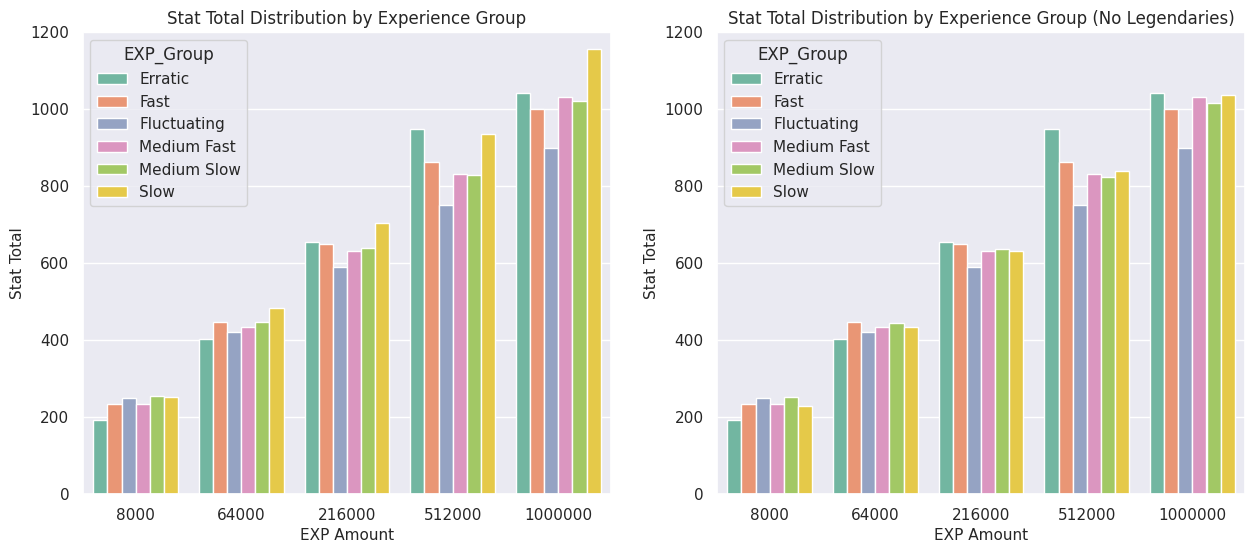

In [ ]:
query1 = """
    SELECT experienceGroups.experience_growth AS EXP_Group,
    AVG(exp8000) AS avg8000,
    AVG(exp64000) AS avg64000,
    AVG(exp216000) AS avg216000,
    AVG(exp512000) AS avg512000,
    AVG(exp1000000) AS avg1000000
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    GROUP BY experienceGroups.experience_growth
    ORDER BY experienceGroups.experience_growth
    ;
    """

query2 = """
    SELECT experienceGroups.experience_growth AS EXP_Group,
    AVG(exp8000) AS avg8000,
    AVG(exp64000) AS avg64000,
    AVG(exp216000) AS avg216000,
    AVG(exp512000) AS avg512000,
    AVG(exp1000000) AS avg1000000
    FROM overview
    INNER JOIN statsExperience
        ON overview.pokedex_number = statsExperience.pokedex_number
    INNER JOIN gameData
        ON overview.pokedex_number = gameData.pokedex_number
    LEFT JOIN experienceGroups
        ON gameData.experience_growth = experienceGroups.total_lvl100
    WHERE is_legendary = 0
    GROUP BY experienceGroups.experience_growth
    ORDER BY experienceGroups.experience_growth
    ;
    """

df1 = pd.read_sql(query1, conn)
df1m = df1.melt('EXP_Group', value_vars=('avg8000', 'avg64000', 'avg216000', 'avg512000', 'avg1000000'), var_name='exp', value_name='stat_total')
df2 = pd.read_sql(query2, conn)
df2m = df2.melt('EXP_Group', value_vars=('avg8000', 'avg64000', 'avg216000', 'avg512000', 'avg1000000'), var_name='exp', value_name='stat_total')

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('Stat Total Distribution by Experience Group')
sns.barplot(
    data=df1m, x='exp', y='stat_total', hue='EXP_Group', ax=ax1
)
ax1.set_xticklabels([8000, 64000, 216000, 512000, 1000000])
ax1.set_xlabel('EXP Amount', fontsize=11)
ax1.set_ylim(0,1200)
ax1.set_ylabel('Stat Total', fontsize=11)

ax2.set_title('Stat Total Distribution by Experience Group (No Legendaries)')
sns.barplot(
    data=df2m, x='exp', y='stat_total', hue='EXP_Group', ax=ax2
)
ax2.set_xticklabels([8000, 64000, 216000, 512000, 1000000])
ax2.set_xlabel('EXP Amount', fontsize=11)
ax2.set_ylim(0,1200)
ax2.set_ylabel('Stat Total', fontsize=11)

fig.set_figheight(6)
fig.set_figwidth(15)

#### With Legendaries
Our results with legendaries tells a conflicting story. The highest average is consistently the Slow group across EXP amounts, but the Erratic group takes second place after 216,600 EXP, and it even pulls ahead at 512,000 EXP. Additionally, the Medium Slow group hovers near the middle of the six groups, not usually high or low comparatively. Quite interesting, considering that the top 10 list represents a fair number of Pokemon in the Medium Slow group. We see that the average Fluctuating Pokemon is persistently weak at all EXP amounts except for 8,000, where it edges out a few of the other groups.

#### Without Legendaries
The results without legendaries is very similar, with the exception of the Slow group, which drops to a mediocre performance even at high EXP amounts. Logically, we can assume from this drop in power that most Legendary Pokemon are in the Slow group. This allows Erratic Pokemon to take the lead in every EXP amount higher than 216,000, with Fast eking out a small advantage at 64,000 EXP and Medium Slow barely edging out Fluctuating at 8,000.

## Conclusion: Which Pokemon are the BEST?
So with all this new information, how did I choose the best team of 6 Pokemon? Let's break down the list.

- **Arceus:** Arceus was an obvious choice. The Gen 4 legendary has a high stat total, an even spread of stats, and its power compared to its experience growth indicates it's easy enough to train.
- **Dialga:** While not well-represented in the experience growth charts, Dialga is a Gen 4 legendary with well-rounded stats and a high base total. Plus, it's a dual type Dragon and Steel Pokemon, representing the two strongest types.
- **Metagross:** The first non-legendary on the list, Metagross is one of the strongest non-legendary Pokemon out there. It's Steel/Psychic type is nothing to sneeze at, and while its stat array is unbalanced, it is easy to train past 216,000 EXP. It's also one of the heavier Pokemon at 550kg.
- **Altaria:** Altaria's speedy growth at later levels and part-Dragon typing makes it a good choice, especially since it levels up faster than the rest of the team. It also has a low catch rate for a non-legendary Pokemon at 45.
- **Wishiwashi:** To be honest, I only picked Wishiwashi because of its extremely cool Ability, Schooling, that gives it an edge in early rounds of battle. That said, Wishiwashi does level up fast, it makes it to the top 10 base totals for non-legendaries, and it's a Gen 7 Pokemon.
- **Dragonite:** A classic Dragon type, Dragonite is at the top of the non-legendary base total list, and while it's a Gen 1 Pokemon, it has a height of 2.2m, setting it above average.

Of course, some parts of this list are subjective. Pokemon like Rayquaza, Mewtwo, Garchomp, and Slaking would also be strong picks for this list, but I happen to like the designs of my choices (go ahead and look them up if you'd like). That said, the choices I made were still informed by the data collected, so I am confident that my chosen team could hold its own in a battle.

### Where do we go from here?
There's a lot we can take from this analysis that goes beyond finding the "best" team of Pokemon. Here are a few takeaways that might impact your play:
- When choosing which game to play, choose a Gen 4 or Gen 7 game to get access to the strongest Pokemon.
- If you want to limit yourself to one type of Pokemon, you should probably pick Dragon, Steel, Fighting, or Ice to have the best chance of winning.
- When your opponent's Pokemon is extremely tall or extremely heavy, there's a good chance that it's strong, so you'll have to factor that into which Pokemon you use in response.
- To catch the strongest Pokemon, search for Pokemon with low catch rates, which might require special Poke Balls or status conditions.
- If you want to train most efficiently, choose Pokemon in the Fluctuating or Fast groups at early levels, then switch to Erratic and Slow Pokemon for later levels.

### Future Study
There's a lot of leftover space for future study. I touched on the variances that exist in the Experience Growth segment, including IVs, EVs, Natures and evolution, and I'd love to explore those in a deeper investigation. Additionally, there are values associated with Pokemon that I haven't even considered yet, including which types are most effective against it, how long it takes to hatch its eggs, and its natural disposition towards its trainer.